In [13]:
from tokenizers import Tokenizer
from fourm.vq.vqvae import VQVAE, DiVAE
import os
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import cv2
from IPython.display import display, clear_output
import time
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import requests
from transformers import BlipProcessor, BlipForConditionalGeneration
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from fourm.data.modality_transforms import RGBTransform
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD, IMAGENET_DEFAULT_STD, IMAGENET_DEFAULT_MEAN
# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

/home/skalli/.local/lib/python3.10/site-packages/fourm/vq/quantizers/quantize_lucid.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/skalli/.local/lib/python3.10/site-packages/fourm/vq/quantizers/quantize_lucid.py:388: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


xFormers not available
xFormers not available


In [ ]:
# ---------- Models ----------

device = "cuda" if torch.cuda.is_available() else "cpu"

image_tokenizer = ImageTokenizer(
    checkpoint_enc="/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/encoder.jit",
    checkpoint_dec="/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/decoder.jit",
).to(device)

processor  = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

In [24]:
"""
Process Penn Action video 0001
 • RGB   → Cosmos tokens        → output/train/tok_rgb/00001.npy …
 • Pose  → Cosmos tokens        → output/train/tok_pose/00001.npy …
 • (x,y) → normalised + vis     → output/train/coords/00001.npy …
 • BLIP caption  → JSON         → output/train/captions/00001.json
"""

# ---------- Imports & config ----------
import os, json
import numpy as np
import torch
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw
import scipy.io
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
from cosmos_tokenizer.image_lib import ImageTokenizer

# ---------- Paths ----------
video_id      = "0001"
frames_root   = "../project/penn_action_raw/Penn_Action/frames"
labels_root   = "../project/penn_action_raw/Penn_Action/labels"
out_root      = "output/dump/train"

tok_rgb_dir   = f"{out_root}/tok_rgb"
tok_pose_dir  = f"{out_root}/tok_pose"
coords_dir    = f"{out_root}/coords"
captions_dir  = f"{out_root}/captions"
for d in (tok_rgb_dir, tok_pose_dir, coords_dir, captions_dir):
    os.makedirs(d, exist_ok=True)

# ---------- Helpers ----------
def encode_rgb(img: Image.Image) -> np.ndarray:
    ten = TF.to_tensor(img).unsqueeze(0).to(device) * 2 - 1
    with torch.inference_mode():
        tok, _ = image_tokenizer.encode(ten)
    return tok.squeeze(0).cpu().short().numpy()

def draw_pose(x, y, vis, size=640) -> Image.Image:
    edges = [(1,2),(1,3),(2,4),(3,5),(4,6),(7,8),(7,9),
             (8,10),(9,11),(10,12)]
    canvas = Image.new("RGBA", (size, size), (0,0,0,255))
    drw = ImageDraw.Draw(canvas)
    for j in range(13):
        if vis[j]:
            cx, cy = int(x[j]), int(y[j])
            r = 5 if j==0 else 3
            drw.ellipse((cx-r, cy-r, cx+r, cy+r),
                        outline="red" if j==0 else None,
                        width=2 if j==0 else 0,
                        fill=(255,0,0,255) if j!=0 else None)
    for j1,j2 in edges:
        if vis[j1] and vis[j2]:
            drw.line([(int(x[j1]),int(y[j1])),(int(x[j2]),int(y[j2]))],
                     fill="red", width=2)
    if vis[0] and vis[7] and vis[8]:
        hip = tuple(np.mean([[x[7],y[7]],[x[8],y[8]]],0).astype(int))
        drw.line([(int(x[0]),int(y[0])), hip], fill="red", width=2)
    return canvas.convert("RGB")

def encode_pose(x,y,vis):
    return encode_rgb(draw_pose(x,y,vis))

def caption_image(img: Image.Image):
    inputs = processor(images=img, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs, max_length=30)
    return processor.decode(out[0], skip_special_tokens=True)

# ---------- Load labels (new) ----------
mat_path = os.path.join(labels_root, f"{video_id}.mat")
mat = scipy.io.loadmat(mat_path, squeeze_me=True, struct_as_record=False)

# in Penn Action the struct is the only non-__ key (often "label")
struct_key = next(k for k in mat.keys() if not k.startswith("__"))
info = mat[struct_key]

x_all  = mat['x']            # (T, 13) double
y_all  = mat['y']           # (T, 13)
vis_all= mat['visibility'].astype(bool)  # (T, 13)
T      = int(mat['nframes'])
H0, W0,_= mat['dimensions']  # original height, width
scale_x, scale_y = 640.0 / W0, 640.0 / H0

# ---------- Frames ----------
frame_dir   = os.path.join(frames_root, video_id)
frame_names = sorted(f for f in os.listdir(frame_dir)
                     if f.lower().endswith((".jpg",".png")))
assert len(frame_names) == T, \
    f"Frame/label mismatch {len(frame_names)} vs {T}"

for i, fname in enumerate(tqdm(frame_names, desc=video_id)):
    stem = f"{i+1:05d}"

    # RGB tokens -------------------------------------------------------------
    img = Image.open(os.path.join(frame_dir, fname)).resize((640,640))
    np.save(f"{tok_rgb_dir}/{stem}.npy", encode_rgb(img))

    # Pose tokens & coords ---------------------------------------------------
    x  = x_all[i] * scale_x            # (13,)
    y  = y_all[i] * scale_y
    vis= vis_all[i]

    np.save(f"{tok_pose_dir}/{stem}.npy", encode_pose(x,y,vis))

    coords = np.stack([x/640.0, y/640.0, vis.astype(float)])  # (3,13)
    np.save(f"{coords_dir}/{stem}.npy", coords)

    # Caption ---------------------------------------------------------------
    cap = caption_image(img)
    with open(f"{captions_dir}/{stem}.json","w") as fp:
        json.dump({"video": video_id, "frame": stem, "caption": cap}, fp, indent=2)

print("✅ Done →", out_root)


0001: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:36<00:00,  4.11it/s]

✅ Done → output/dump/train


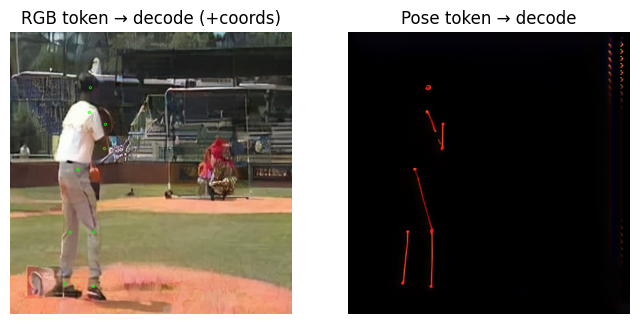

Caption: a baseball player is getting ready to hit the ball


In [25]:
# ---------------------------------------------------------
# Quick visual sanity-check for Penn-Action preprocessing
# ---------------------------------------------------------
import os, json, numpy as np, torch
import matplotlib.pyplot as plt
from PIL import ImageDraw
from cosmos_tokenizer.image_lib import ImageTokenizer

# ---------------- paths / settings ----------------
idx        = 1                         # 1 → 00001.npy, 2 → 00002.npy, …
root       = "output/dump/train"
tok_rgb_p  = f"{root}/tok_rgb/{idx:05d}.npy"
tok_pose_p = f"{root}/tok_pose/{idx:05d}.npy"
coords_p   = f"{root}/coords/{idx:05d}.npy"
cap_p      = f"{root}/captions/{idx:05d}.json"

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- load + decode ------------------
tok_rgb  = torch.from_numpy(np.load(tok_rgb_p)).unsqueeze(0).to(device)
tok_pose = torch.from_numpy(np.load(tok_pose_p)).unsqueeze(0).to(device)

with torch.inference_mode():
    rgb_img  = image_tokenizer.decode(tok_rgb).clamp(-1,1)[0]   # (-1,1) tensor CHW
    pose_img = image_tokenizer.decode(tok_pose).clamp(-1,1)[0]

# to PIL for display
to_pil = lambda t: ( (t.cpu()+1)/2 * 255 ).byte()
rgb_pil  = Image.fromarray(to_pil(rgb_img).permute(1,2,0).numpy())
pose_pil = Image.fromarray(to_pil(pose_img).permute(1,2,0).numpy())

# ---------------- overlay joints ------------------
coords = np.load(coords_p)            # shape (3,13)   rows: x_norm, y_norm, vis
x, y, vis = coords
x_pix = x * 640
y_pix = y * 640

draw = ImageDraw.Draw(rgb_pil)
for xp, yp, v in zip(x_pix, y_pix, vis):
    if v:
        draw.ellipse((xp-3, yp-3, xp+3, yp+3), outline="lime", width=2)

# ---------------- show ---------------------------
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("RGB token → decode (+coords)")
plt.axis("off")
plt.imshow(rgb_pil)

plt.subplot(1,2,2)
plt.title("Pose token → decode")
plt.axis("off")
plt.imshow(pose_pil)
plt.show()

# ---------------- caption ------------------------
with open(cap_p) as fp:
    caption = json.load(fp)["caption"]
print("Caption:", caption)